# Mahan Madani
## Artificial Neural Networks 3rd Project


In [1]:
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda device")
    
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

using cuda device


### Download and load Intel Image Classification Dataset (25k samples):
For Google Colab: Done via the code below.
<br>Can also be downloaded and placed manually

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# ! pip install kaggle
# ! mkdir ~/ .kaggle
# ! cp /content/drive/MyDrive/CS/ANN/3/kaggle.json  /root/.kaggle/
# ! chmod 600 ~/ .kaggle/kaggle.json

# ! kaggle datasets download -d puneet6060/intel-image-classification

In [5]:
# import zipfile
# with zipfile.ZipFile("/content/intel-image-classification.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/intel-image-classification")

In [6]:
transform = transforms.Compose([transforms.Resize((150, 150)),transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

train_set = tv.datasets.ImageFolder("./content/intel-image-classification/seg_train/seg_train", transform=transform)
test_set = tv.datasets.ImageFolder("./content/intel-image-classification/seg_test/seg_test", transform=transform)

In [7]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=True)

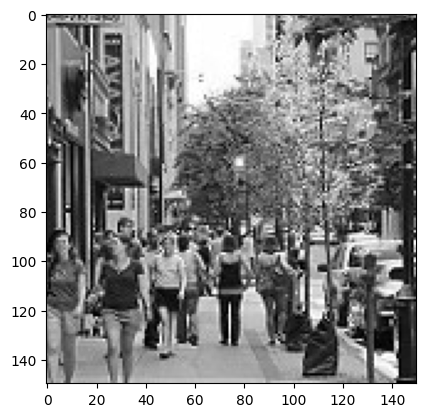

In [8]:
images = iter(test_loader)
input, target = next(images)
plt.imshow(input[0][0], cmap='gray')
plt.show()

### Define Loss function and train/test models
we'll use Croos Entropy as the loss function and SGD as the Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def test_model(model):
    with torch.no_grad():
        test_loss = 0
        accuracy = 0
        model.eval()

        for input, target in test_loader:
            input = input.to(device)
            target = target.to(device)

            output = model.forward(input)
            loss = criterion(output, target)
            test_loss += loss.item()

            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    
    test_loss = test_loss / len(test_loader)
    model.test_loss_list.append(test_loss)
    
    test_accuracy = accuracy / len(test_loader)
    model.accuracy_list.append(test_accuracy)
    
    print(f"test loss: {test_loss: <20}   test accuracy: {test_accuracy: <20}")

In [11]:
def train_model(model, optimizer_name, epochs, learning_rate):

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.1)
    
    for i in range(epochs):
        current_loss = 0
        model.train()

        for input, target in train_loader:
            optimizer.zero_grad()
            input = input.to(device)
            target = target.to(device)

            #forward-pass
            output = model.forward(input)
            loss = criterion(output, target)

            #backward-pass
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
            

        train_loss = current_loss / len(train_loader)
        model.train_loss_list.append(train_loss)

        # At completion of epoch
        lr_scheduler.step()
        print(f"Epoch: {i+1: >3}/{epochs}   training loss: {train_loss: <20}", end="   ")
        test_model(model)

In [12]:
def generate_loss_plot(model):
    plt.plot(model.train_loss_list, label = "Training loss")
    plt.plot(model.test_loss_list, label = "Test loss")
    plt.legend(frameon = False)
    plt.show()

In [13]:
def generate_accuracy_plot(model):
    plt.plot(model.accuracy_list, label = "Accuracy")
    plt.legend(frameon = False)
    plt.show()

In [14]:
def run_model(model, optimizer, epochs, learning_rate):
    start_time = time()
    train_model(model, optimizer, epochs, learning_rate)
    generate_loss_plot(model)
    generate_accuracy_plot(model)
    end_time = time()
    print(f"Total time spent: {end_time - start_time} seconds")

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def calculate_confusion_matrix(model):
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            output = model(inputs.to(device)) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(classes), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
#     plt.savefig('output.png')

## define a parent class for all models

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.train_loss_list = []
        self.test_loss_list = []
        self.accuracy_list = []


# 1. Implementing ResNet from scratch

### I used the block structure shown below to design a simple ResNet.

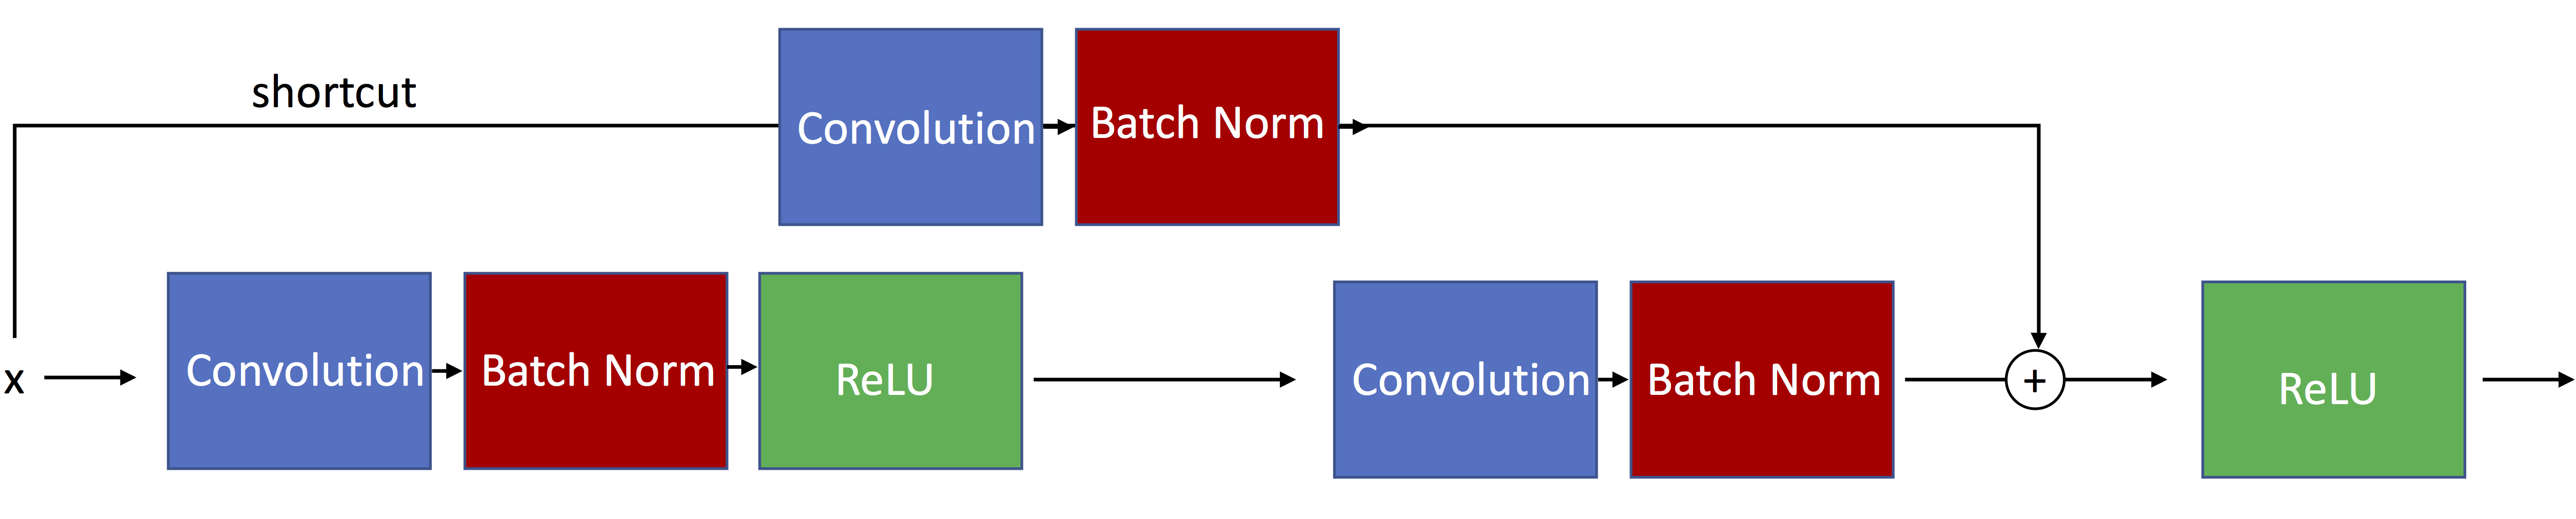

To avoid repeating  the same lines of code, the ResidualBlock class is defined which is based on the structure above.
<br> The residual part of the network is implemented using 1x1 convolution.

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.block = nn.Sequential(
                nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels[1], channels[2], 1, stride=1, padding=0),
                nn.BatchNorm2d(channels[2])
        ).to(device)

        self.shortcut = nn.Sequential(
                nn.Conv2d(channels[0], channels[2], 1, stride=2, padding=0),
                nn.BatchNorm2d(channels[2])
        ).to(device)
            
    def forward(self, x):
        shortcut = x
        
        block = self.block(x)
        shortcut = self.shortcut(x)    
        x = torch.relu(block + shortcut)

        return x

In [21]:
class Implemented_ResNet(Model):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.res_block_1 = ResidualBlock(channels=[3, 16, 32])
        self.res_block_2 = ResidualBlock(channels=[32, 64, 64])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res_block_3 = ResidualBlock(channels=[64, 128, 128])
        self.res_block_4 = ResidualBlock(channels=[128, 64, 64]) 

        self.fc1 = nn.Linear(1600, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 6)

        
    def forward(self, x):

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = torch.relu(self.pool(x))
        x = self.res_block_3(x)
        x = self.res_block_4(x)

        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn_linear(x))
        x = self.fc2(x)
        return x


Epoch:   1/15   training loss: 1.034466298601844      test loss: 0.821585901081562      test accuracy: 0.7027994990348816  
Epoch:   2/15   training loss: 0.6636154678734866     test loss: 0.7008813048402468     test accuracy: 0.7330264449119568  
Epoch:   3/15   training loss: 0.5145376706665212     test loss: 0.6559058129787445     test accuracy: 0.7557663917541504  
Epoch:   4/15   training loss: 0.4104089755903591     test loss: 0.7439645926157633     test accuracy: 0.7245163917541504  
Epoch:   5/15   training loss: 0.3150038793683052     test loss: 0.5938661557932695     test accuracy: 0.7967355251312256  
Epoch:   6/15   training loss: 0.24540645371783865    test loss: 0.6577707976102829     test accuracy: 0.762276828289032   
Epoch:   7/15   training loss: 0.17773501283743165    test loss: 0.7256935300926367     test accuracy: 0.7453961968421936  
Epoch:   8/15   training loss: 0.13086844953623686    test loss: 0.7210884069403013     test accuracy: 0.760323703289032   
Epoch:  

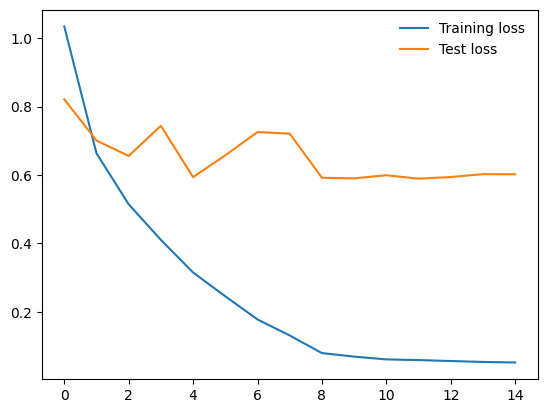

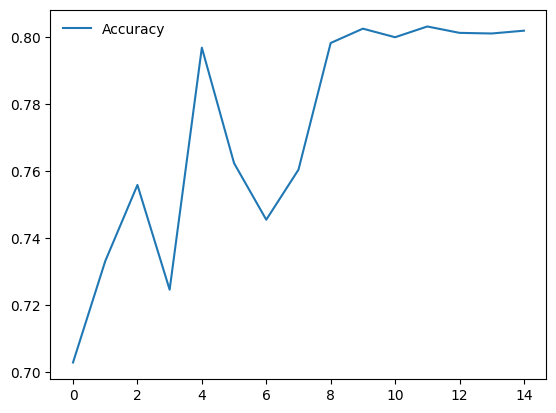

Total time spent: 304.6217818260193 seconds


In [23]:
implemented_resNet = Implemented_ResNet().to(device)
run_model(implemented_resNet, "SGD", epochs=15, learning_rate=0.02)

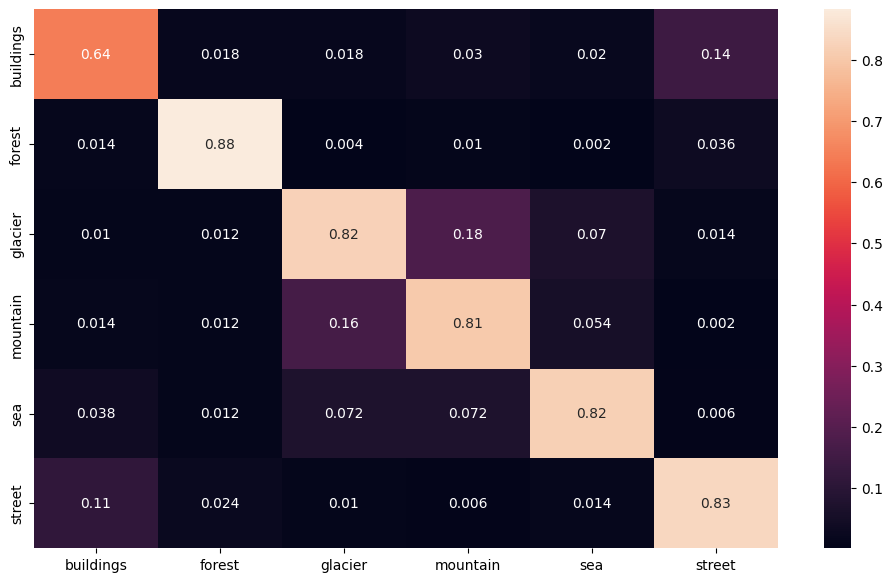

In [24]:
calculate_confusion_matrix(implemented_resNet)

### Analysis
Compared to the other models (especially pre-trained ones) my implementation of ResNet is inaccurate. A more complex architecture with more depth and width will surely provide better results.

# 2. Using a pre-trained model

Here are 4 of the tests I ran on previously trained models. They all share the same fully connected layers at end, so that they can be compared more easily.



## 2.1. ResNet34

In [20]:
class ResNet34(Model):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet34(weights=tv.models.ResNet34_Weights.IMAGENET1K_V1).to(device)
        
        self.fc1 = nn.Linear(self.model.fc.out_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

        
    def forward(self, x):
        x = self.model(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.bn2(x))
        x = self.fc3(x)
        
        return x

Epoch:   1/40   training loss: 0.8079098671674728     test loss: 0.4350721488396327     test accuracy: 0.9035528302192688  
Epoch:   2/40   training loss: 0.3494314785708081     test loss: 0.30125004053115845    test accuracy: 0.917178213596344   
Epoch:   3/40   training loss: 0.2326833101836118     test loss: 0.25546912600596744    test accuracy: 0.922665536403656   
Epoch:   4/40   training loss: 0.1757367876442996     test loss: 0.24398543468366066    test accuracy: 0.9274553656578064  
Epoch:   5/40   training loss: 0.13316984224048528    test loss: 0.2314509842544794     test accuracy: 0.929501473903656   
Epoch:   6/40   training loss: 0.09934488074346022    test loss: 0.23788130904237428    test accuracy: 0.9268043041229248  
Epoch:   7/40   training loss: 0.07660676298493689    test loss: 0.24037310294806957    test accuracy: 0.930850088596344   
Epoch:   8/40   training loss: 0.05814343358982693    test loss: 0.24248076075067124    test accuracy: 0.9290829300880432  
Epoch:  

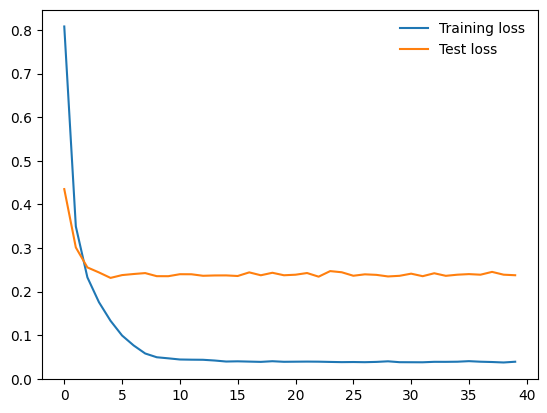

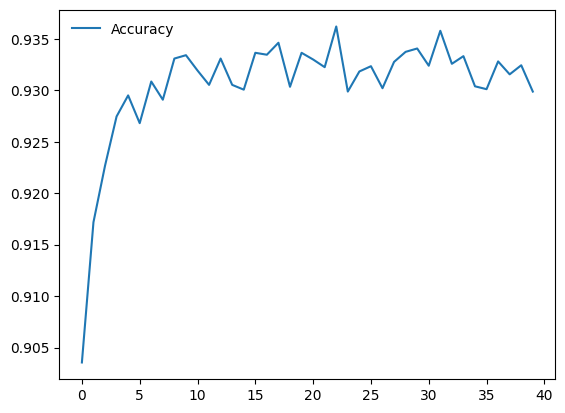

Total time spent: 1339.439026594162 seconds


In [28]:
resnet34 = ResNet34().to(device)
run_model(resnet34, "SGD", 40, 0.01)

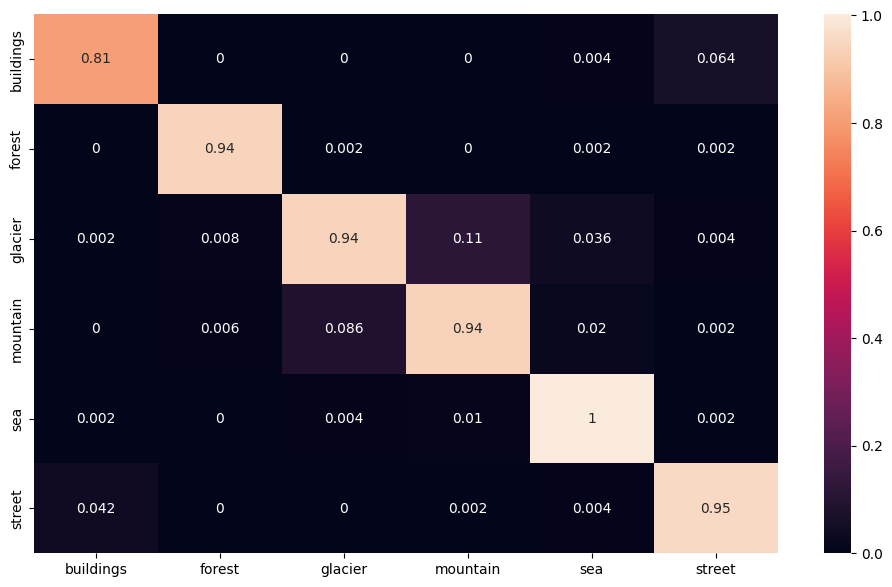

In [39]:
calculate_confusion_matrix(resnet34)

### Analysis
#### Highest accuracy:  0.9361
<br>I deciced to run the first model for 40 epochs to observe the effects of an extended training time. Looking at the results, we can see that after around the 10th epoch, both train and test losses remain mostly the same without any major changes to them. <br>Predictably, Our model isn't overfitted due to the properties of ResNet network, but it also seems to have stopped learning much after the 10th epoch.

## 2.2. ResNet34 (only new fully connected layers optimized)
A different method for transfer learning is to freeze the weights and biases of the pre-trained model and only optimize the newly added fully connected layers. This model is structured the same as the 2.1. model but it only optimizes the FC layers.

In [26]:
class ResNet34_fc_only(Model):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet34(weights=tv.models.ResNet34_Weights.IMAGENET1K_V1).to(device)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(self.model.fc.out_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

        
    def forward(self, x):
        x = self.model(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.bn2(x))
        x = self.fc3(x)
        
        return x

Epoch:   1/20   training loss: 1.0054598461497914     test loss: 0.6722669154405594     test accuracy: 0.8371465802192688  
Epoch:   2/20   training loss: 0.5822425067424775     test loss: 0.5059901115794977     test accuracy: 0.8695126175880432  
Epoch:   3/20   training loss: 0.4617464769970287     test loss: 0.43791546672582626    test accuracy: 0.875558078289032   
Epoch:   4/20   training loss: 0.3952388860962608     test loss: 0.39052748680114746    test accuracy: 0.8793712258338928  
Epoch:   5/20   training loss: 0.351832471110604      test loss: 0.36244134108225506    test accuracy: 0.8865792751312256  
Epoch:   6/20   training loss: 0.3243549719452858     test loss: 0.35401812195777893    test accuracy: 0.8853701949119568  
Epoch:   7/20   training loss: 0.297291994636709      test loss: 0.34908705825606984    test accuracy: 0.8840215802192688  
Epoch:   8/20   training loss: 0.27424448267980056    test loss: 0.34116580337285995    test accuracy: 0.887881338596344   
Epoch:  

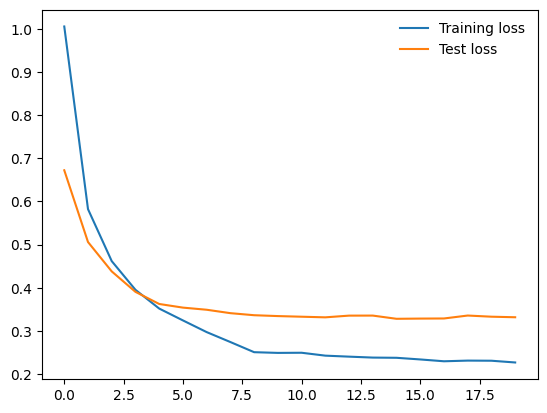

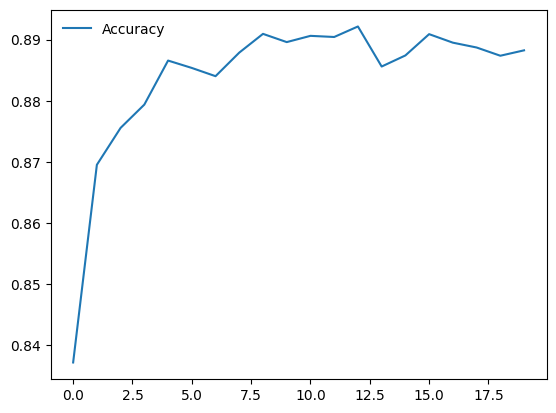

Total time spent: 429.13256335258484 seconds


In [27]:
resnet34_fc_only = ResNet34_fc_only().to(device)
run_model(resnet34_fc_only, "SGD", 20, 0.01)

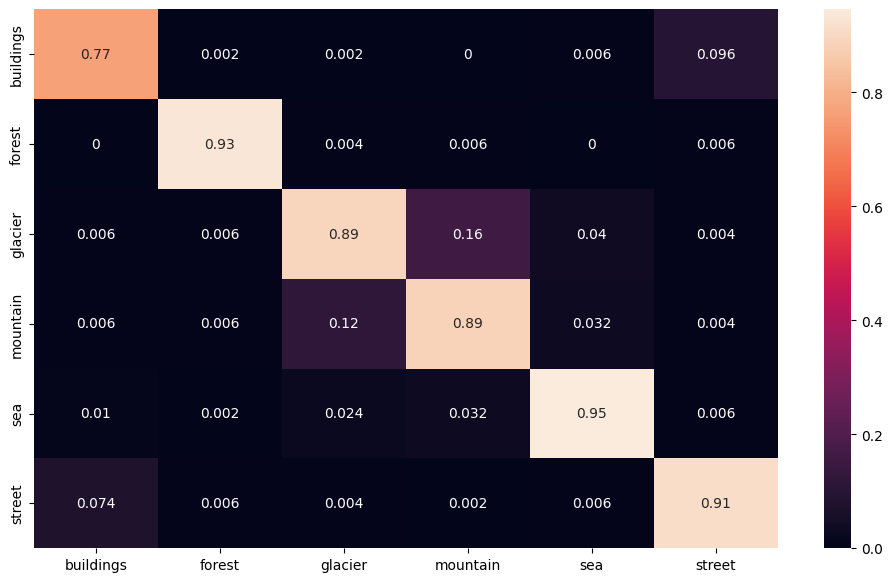

In [28]:
calculate_confusion_matrix(resnet34_fc_only)

### Analysis
The results are mostly similar to the previous model but the accuracy of this model is clearly below the other, with a 4% difference on average. Another difference between the two is the significantly lower time model 2.2. needed to train (429 seconds vs 1339 second) which makes sense, as we're skipping many of the parameters during backpropagation.
<br>I think this method of transfer learning can be useful in some circumstances, especially when we're looking to minimalize the time needed for training (at the cost of accuracy).

## 2.3. WideResNet50

In [23]:
class WideResNet50(Model):
    def __init__(self):
        super().__init__()
        self.model = tv.models.wide_resnet50_2(weights=tv.models.Wide_ResNet50_2_Weights.IMAGENET1K_V2).to(device)
        
        self.fc1 = nn.Linear(self.model.fc.out_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

        
    def forward(self, x):
        x = self.model(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.bn2(x))
        x = self.fc3(x)
        
        return x

Epoch:   1/20   training loss: 0.8986303817142139     test loss: 0.5662843647102515     test accuracy: 0.865792453289032   
Epoch:   2/20   training loss: 0.446530297127637      test loss: 0.4033432826399803     test accuracy: 0.8906714916229248  
Epoch:   3/20   training loss: 0.31210079260847784    test loss: 0.3380933490892251     test accuracy: 0.9020647406578064  
Epoch:   4/20   training loss: 0.23793460767377506    test loss: 0.3041765217979749     test accuracy: 0.9063429832458496  
Epoch:   5/20   training loss: 0.18629259765148162    test loss: 0.28838311073680717    test accuracy: 0.9087147116661072  
Epoch:   6/20   training loss: 0.14923235218633304    test loss: 0.2788193045804898     test accuracy: 0.9138299822807312  
Epoch:   7/20   training loss: 0.11666913493113085    test loss: 0.279204315195481      test accuracy: 0.9142950177192688  
Epoch:   8/20   training loss: 0.09757410064339637    test loss: 0.2743070299426715     test accuracy: 0.9121558666229248  
Epoch:  

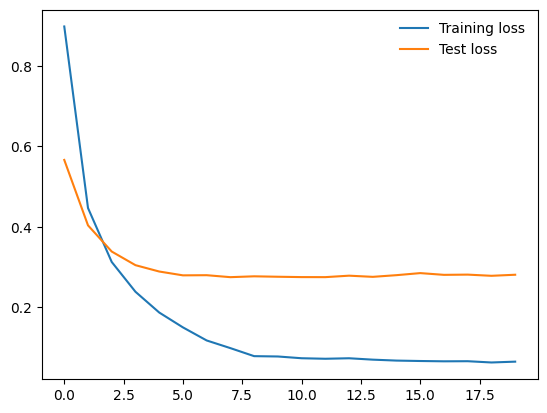

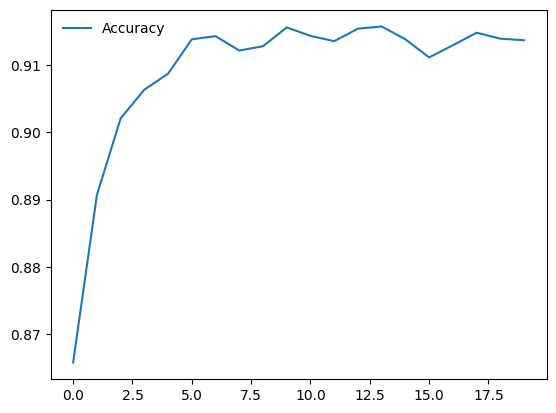

Total time spent: 1871.8477776050568 seconds


In [24]:
wideResnet50 = WideResNet50().to(device)
run_model(wideResnet50, "SGD", 20, 0.01)

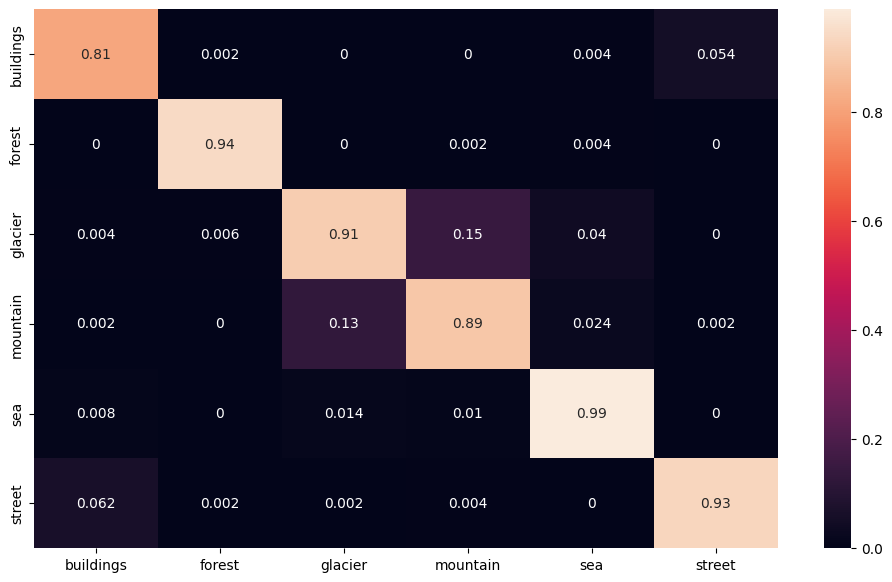

In [25]:
calculate_confusion_matrix(wideResnet50)

### Analysis
Altering the added fully connected layers or changing the optimizer may result in a more accurate network. However, out of all the architectures I experimented with, WideResNet was the most cost heavy and time consuming, taking nearly 30 minutes for 20 epochs. Similar to base ResNet (2.1.) , this model doesn't have any overfitting problems and it also stops learning after a certain epoch.


## 2.4 ResNeXt50_32X4D

In [17]:
class ResNeXt50(Model):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnext50_32x4d(weights=tv.models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2).to(device)
        
        self.fc1 = nn.Linear(self.model.fc.out_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

        
    def forward(self, x):
        x = self.model(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.bn2(x))
        x = self.fc3(x)
        
        return x

Epoch:   1/20   training loss: 0.9804463825442574     test loss: 0.6179843147595724     test accuracy: 0.8554222583770752  
Epoch:   2/20   training loss: 0.49698171561414545    test loss: 0.43802015110850334    test accuracy: 0.8892764449119568  
Epoch:   3/20   training loss: 0.34059026539325715    test loss: 0.36680618797739345    test accuracy: 0.8985769748687744  
Epoch:   4/20   training loss: 0.2536958919330077     test loss: 0.335632037371397      test accuracy: 0.9004371166229248  
Epoch:   5/20   training loss: 0.18990221639925783    test loss: 0.31373406077424687    test accuracy: 0.9077381491661072  
Epoch:   6/20   training loss: 0.14964287999001416    test loss: 0.302270049850146      test accuracy: 0.9102027416229248  
Epoch:   7/20   training loss: 0.11972194926982577    test loss: 0.29879840711752575    test accuracy: 0.9126209616661072  
Epoch:   8/20   training loss: 0.10043984282423149    test loss: 0.3064524258176486     test accuracy: 0.9121558666229248  
Epoch:  

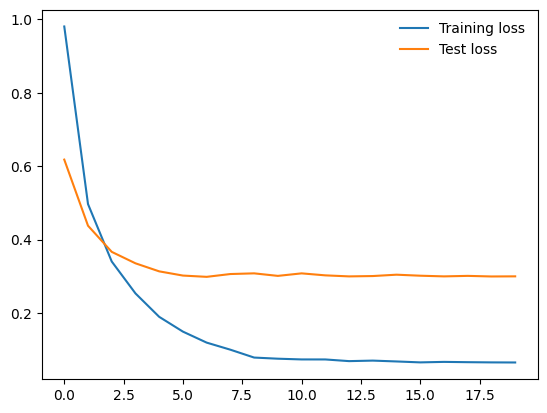

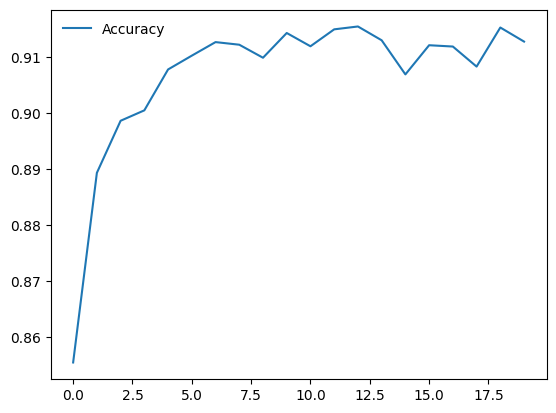

Total time spent: 1327.7566466331482 seconds


In [18]:
resNext50 = ResNeXt50().to(device)
run_model(resNext50, "SGD", 20, 0.01)

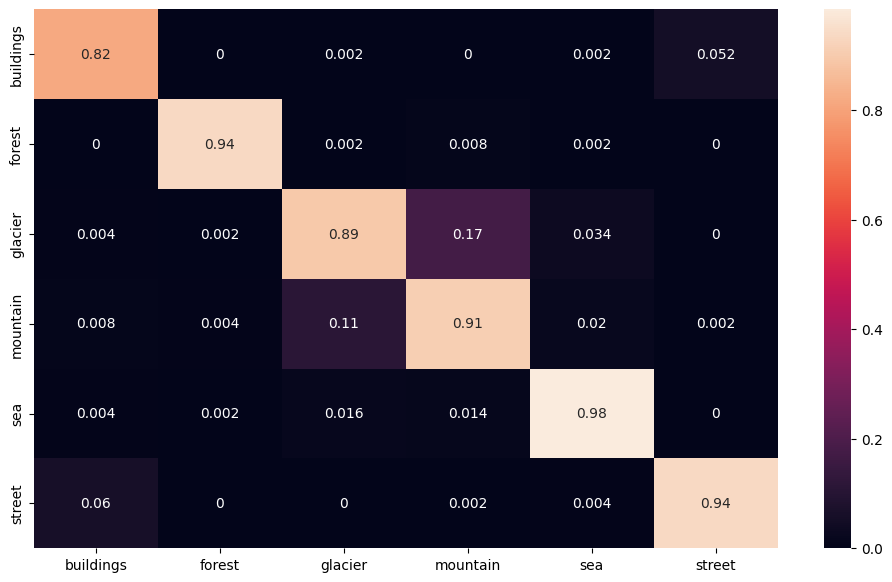

In [19]:
calculate_confusion_matrix(resNext50)

### Analysis
Despite taking less time to train than WideResNet, ResNeXt seems to perform similarly if not slightly better. As explained in Exercise 2, ResNeXt has to optimize a lower amount of variables during backpropagation, resulting in less training time overall.

### Confusion Matrix Analysis
The confusion matrices generated by these 5 models have a lot in common with eachother. "Sea" and "Forest" have the best results overall, while "buildings" has the lowest accuracy among all models (mostly confused with "street"). There may some images in the dataset which feature both "street" and "buildings", causing this to happen. Additionally, "Mountains" and "Glaciers" share a similar structures in general, which my casue the Model to confuse these two.